# Look at the Mixing layer depths in the different model resolutions. 

In [1]:
# load appropriate modules
import numpy as np
import xarray as xr
from xmitgcm import open_mdsdataset
from matplotlib import pyplot as plt
%matplotlib inline
from xgcm import Grid
from scipy import linalg as lin
from scipy import signal as sig
from scipy import fftpack as fft
from scipy import interpolate as naiso
from matplotlib import colors, ticker, cm
import xrft
#import gsw

In [2]:
# Make dictionary
res_time = {"20":{'dt':1200, 'iter1': 5702400, 'iterend':5728320},
            "05":{'dt':300, 'iter1':10368000, 'iterend':10471680}, 
            "01":{'dt':40 , 'iter1':1166400, 'iterend':1944000}}

for keys in res_time.keys():
    res_time[keys]['dirname']='/swot/SUM05/dbalwada/channel_beta/{0}km/tracer_exp1/'.format(keys)

In [3]:
res_time['20']['dt_out'] = 18
res_time['05']['dt_out'] = 72
res_time['01']['dt_out'] = 21600

In [4]:
# Load data
for keys in res_time.keys():
    
    npick = 1 # pick up every npick'th file as the original out is very dense (12 hours)
    
    dt_out = int(res_time[keys]['dt_out'])
    T1 = int(res_time[keys]['iter1'])
    
    T2 = int(res_time[keys]['iterend'])
    T360days = T2
    
    if keys == '01':
        npick=1
        T360days = T2 
    
    iters = range(T1+ dt_out, T360days+dt_out, dt_out*npick)
    
    ds = open_mdsdataset(res_time[keys]['dirname'], iters = iters, 
                             delta_t=res_time[keys]['dt'], prefix=['KPP_surf', 'KPP_parameters', 'T']
                     ,ignore_unknown_vars=True, geometry='cartesian')
    res_time[keys]['data_others']=ds

/home/dbalwada/miniconda/envs/dhruvenv/lib/python3.5/site-packages/xmitgcm-0.2.1-py3.5.egg/xmitgcm/utils.py:314: UserWarning: Not sure what to do with rlev = L
  warnings.warn("Not sure what to do with rlev = " + rlev)
/home/dbalwada/miniconda/envs/dhruvenv/lib/python3.5/site-packages/xmitgcm-0.2.1-py3.5.egg/xmitgcm/mds_store.py:235: FutureWarning: iteration over an xarray.Dataset will change in xarray v0.11 to only include data variables, not coordinates. Iterate over the Dataset.variables property instead to preserve existing behavior in a forwards compatible manner.
  for vname in ds:


In [5]:
def time_average(ds, n): 
    l = len(ds.time)/n
    
    temp = []
    temp_time = []
    for j in range(0, int(l)):
        
        temp.append(ds.isel(time=slice(j*n, (j+1)*n-1)).mean('time'))
        
        temp_time.append(ds.time.isel(time=(j+1)*n-1))

    ds_coarse = xr.concat(temp, temp_time)
    ds_coarse = ds_coarse.rename({'concat_dim':'time'})
    
    return ds_coarse

In [6]:
res_time

{'01': {'data_others': <xarray.Dataset>
  Dimensions:              (XC: 2000, XG: 2000, YC: 2000, YG: 2000, Z: 76, Zl: 76, Zp1: 77, Zu: 76, layer_1TH_bounds: 43, layer_1TH_center: 42, layer_1TH_interface: 41, time: 36)
  Coordinates:
      iter                 (time) int64 dask.array<shape=(36,), chunksize=(1,)>
    * time                 (time) int64 47520000 48384000 49248000 50112000 ...
    * YG                   (YG) >f4 0.0 1000.0 2000.0 3000.0 4000.0 5000.0 ...
    * YC                   (YC) >f4 500.0 1500.0 2500.0 3500.0 4500.0 5500.0 ...
    * XC                   (XC) >f4 500.0 1500.0 2500.0 3500.0 4500.0 5500.0 ...
    * XG                   (XG) >f4 0.0 1000.0 2000.0 3000.0 4000.0 5000.0 ...
    * Zl                   (Zl) >f4 0.0 -1.0 -2.14 -3.44 -4.93 -6.63 -8.56 ...
    * Z                    (Z) >f4 -0.5 -1.57 -2.79 -4.185 -5.78 -7.595 -9.66 ...
    * Zu                   (Zu) >f4 -1.0 -2.14 -3.44 -4.93 -6.63 -8.56 -10.76 ...
    * Zp1                  (Zp1) >f4 0.0 -1

In [7]:
res_coarse = {}
res_coarse['01'] = res_time['01']['data_others']
res_coarse['01'].load()

for keys in ['20','05']:
    res_coarse[keys] = time_average(res_time[keys]['data_others'],40 )
    res_coarse[keys].load()

In [8]:
res_coarse

{'01': <xarray.Dataset>
 Dimensions:              (XC: 2000, XG: 2000, YC: 2000, YG: 2000, Z: 76, Zl: 76, Zp1: 77, Zu: 76, layer_1TH_bounds: 43, layer_1TH_center: 42, layer_1TH_interface: 41, time: 36)
 Coordinates:
     iter                 (time) int64 1188000 1209600 1231200 1252800 ...
   * time                 (time) int64 47520000 48384000 49248000 50112000 ...
   * YG                   (YG) >f4 0.0 1000.0 2000.0 3000.0 4000.0 5000.0 ...
   * YC                   (YC) >f4 500.0 1500.0 2500.0 3500.0 4500.0 5500.0 ...
   * XC                   (XC) >f4 500.0 1500.0 2500.0 3500.0 4500.0 5500.0 ...
   * XG                   (XG) >f4 0.0 1000.0 2000.0 3000.0 4000.0 5000.0 ...
   * Zl                   (Zl) >f4 0.0 -1.0 -2.14 -3.44 -4.93 -6.63 -8.56 ...
   * Z                    (Z) >f4 -0.5 -1.57 -2.79 -4.185 -5.78 -7.595 -9.66 ...
   * Zu                   (Zu) >f4 -1.0 -2.14 -3.44 -4.93 -6.63 -8.56 -10.76 ...
   * Zp1                  (Zp1) >f4 0.0 -1.0 -2.14 -3.44 -4.93 -6.63 -8.56

do the analysis on data that has been averaged over 10 days, because that is what we have for now. 

In [9]:
# get all the time axis to be the same.
for keys in res_time.keys():

    time_updated =  (res_coarse[keys].time -  res_coarse[keys].time[0]) + (res_coarse[keys].time[1] - res_coarse[keys].time[0])
    res_coarse[keys].__setitem__('time', time_updated.values)

    #time_updated2 = res_time[keys]['data_main'].time - res_time[keys]['data_main'].time[0] 
    #res_time[keys]['data_main'].__setitem__('time', time_updated2.values)
    

/home/dbalwada/miniconda/envs/dhruvenv/lib/python3.5/site-packages/xarray/plot/utils.py:51: FutureWarning: 'pandas.tseries.converter.register' has been moved and renamed to 'pandas.plotting.register_matplotlib_converters'. 
  converter.register()


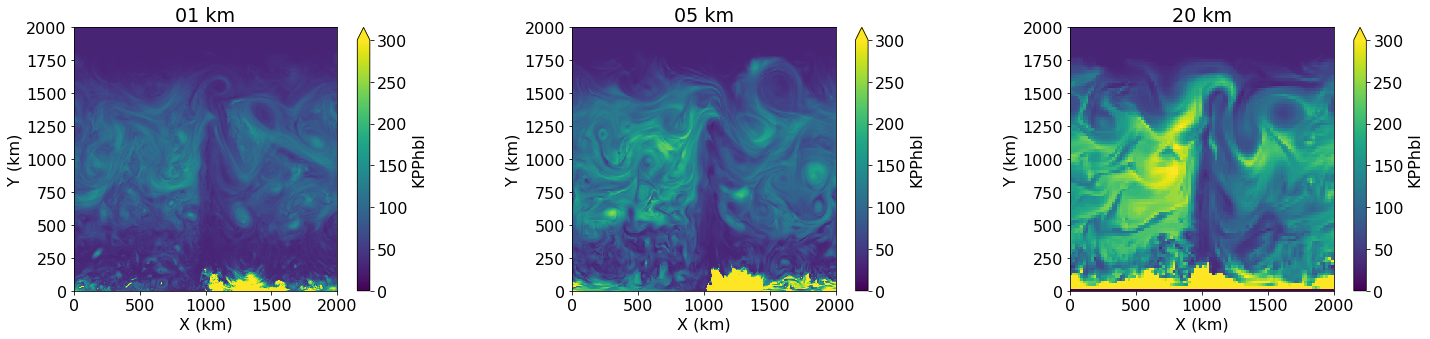

In [10]:
# Mixing LD synoptic (10 day average)
res = sorted(res_time.keys())
fig = plt.figure(figsize=(21,5))
plt.rcParams['font.size'] = 16
plt.rcParams['figure.autolayout'] =True
n=0
for key in res:
    ax = fig.add_subplot(131+n)
    

    res_coarse[key].KPPhbl.isel(time=-1).plot(vmax=300)
    plt.title(key +' km')
    a=ax.get_xticks()
    a = (a/1e3).astype(int)
    ax.set_xticklabels(a) 
    a=ax.get_yticks()
    a = (a/1e3).astype(int)
    ax.set_yticklabels(a) 
    ax.set_aspect('equal')
    plt.xlabel('X (km)')
    plt.ylabel('Y (km)')    
    n+=1
    
    
plt.tight_layout()
plt.savefig('figures_MLD/MLD_map_synoptic.png', format='png', dpi=300)

/home/dbalwada/miniconda/envs/dhruvenv/lib/python3.5/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


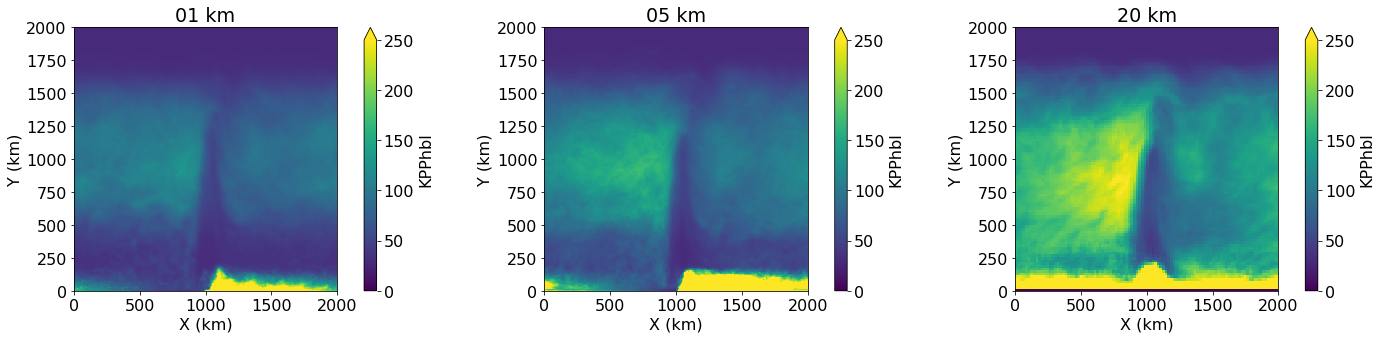

In [89]:
# Mixing LD mean
res = sorted(res_time.keys())
fig = plt.figure(figsize=(21,5))
plt.rcParams['font.size'] = 16
plt.rcParams['figure.autolayout'] =True

n=0
for key in res:
    ax = fig.add_subplot(131+n)
    res_coarse[key].KPPhbl.mean('time').plot(vmax=250)
    plt.title(key +' km')
    n+=1
    a=ax.get_xticks()
    a = (a/1e3).astype(int)
    ax.set_xticklabels(a) 
    a=ax.get_yticks()
    a = (a/1e3).astype(int)
    ax.set_yticklabels(a) 
    ax.set_aspect('equal')
    plt.xlabel('X (km)')
    plt.ylabel('Y (km)')
    
plt.tight_layout()
plt.savefig('figures_MLD/MLD_map_mean.png', format='png', dpi=300)

In [36]:
start = 0.0
stop = 1.0
number_of_lines=9
cm_subsection = np.linspace(start, stop, number_of_lines) 
colors = [ plt.cm.Set1(x) for x in cm_subsection ]

/home/dbalwada/miniconda/envs/dhruvenv/lib/python3.5/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/home/dbalwada/miniconda/envs/dhruvenv/lib/python3.5/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/home/dbalwada/miniconda/e

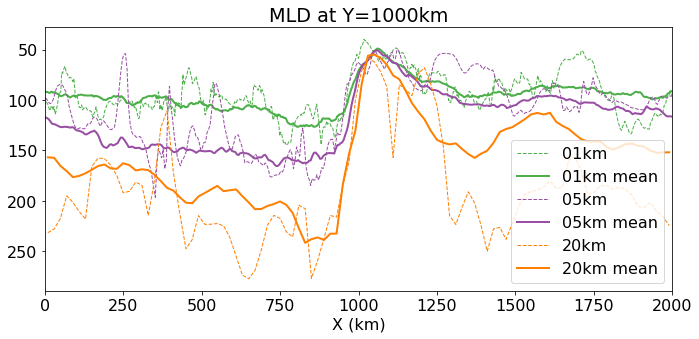

In [90]:
# Mixing LD 
res = sorted(res_time.keys())
plt.figure(figsize=(10,5))
plt.rcParams['font.size'] = 16
plt.rcParams['figure.autolayout'] =True

n=2
for key in res:
    plt.subplot(111)
    X = res_coarse[key].XC/1e3
    Y = res_coarse[key].KPPhbl.sel(YC=1000e3,method='nearest'
                              ).isel(time=-1)
        
    Ym = res_coarse[key].KPPhbl.sel(YC=1000e3,method='nearest'
                              ).mean('time')
    
    plt.plot(X,Y, '--', linewidth=1, label=key+'km', color=colors[n])

    plt.plot(X,Ym, linewidth=2, label=key+'km mean', color=colors[n])
    #plt.title(key +' km')
    n+=1
plt.legend()
plt.gca().invert_yaxis()
plt.tight_layout()
plt.title('MLD at Y=1000km')
plt.xlabel('X (km)')
plt.xlim([0,2000])
plt.savefig('figures_MLD/MLD_zonal.eps', format='eps', dpi=90)

/home/dbalwada/miniconda/envs/dhruvenv/lib/python3.5/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/home/dbalwada/miniconda/envs/dhruvenv/lib/python3.5/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/home/dbalwada/miniconda/e

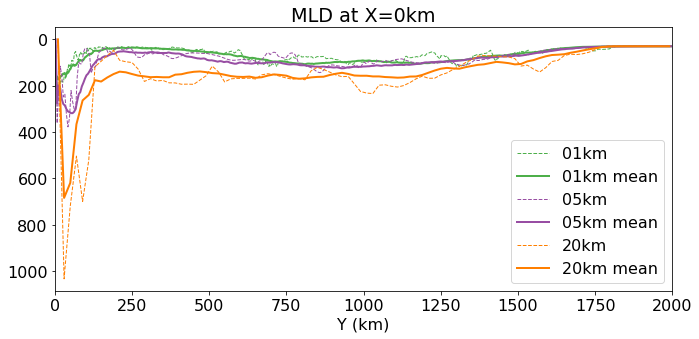

In [91]:
# Mixing LD 
res = sorted(res_time.keys())
plt.figure(figsize=(10,5))
plt.rcParams['font.size'] = 16
plt.rcParams['figure.autolayout'] =True

n=2
for key in res:
    plt.subplot(111)
    X = res_coarse[key].YC/1e3
    Y = res_coarse[key].KPPhbl.sel(XC=0e3,method='nearest'
                              ).isel(time=-1)
        
    Ym = res_coarse[key].KPPhbl.sel(XC=0e3,method='nearest'
                              ).mean('time')
    
    plt.plot(X,Y, '--', linewidth=1, label=key+'km', color=colors[n])

    plt.plot(X,Ym, linewidth=2, label=key+'km mean', color=colors[n])
    #plt.title(key +' km')
    n+=1
plt.legend()

plt.gca().invert_yaxis()
plt.tight_layout()
plt.title('MLD at X=0km')
plt.xlabel('Y (km)')
plt.xlim([0,2000])
plt.savefig('figures_MLD/MLD_meridional.eps', format='eps', dpi=90)

/home/dbalwada/miniconda/envs/dhruvenv/lib/python3.5/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


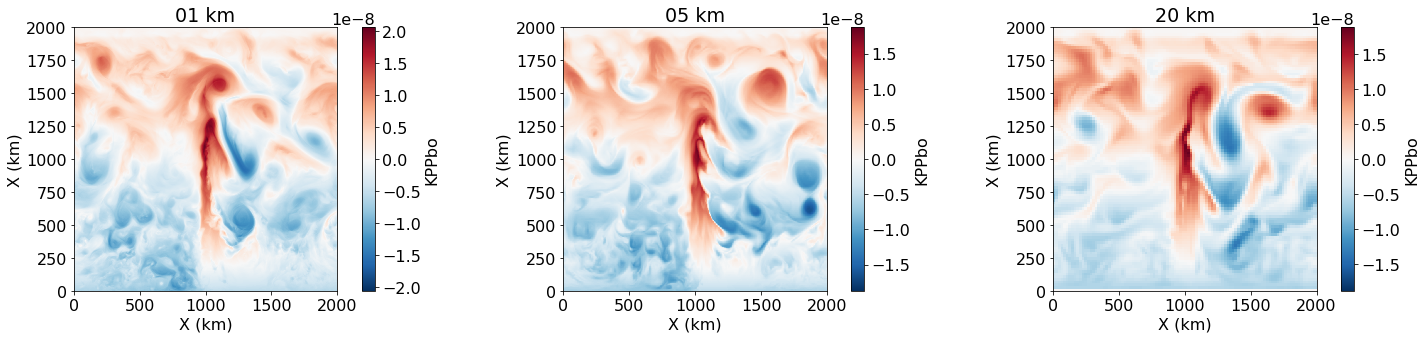

In [70]:
# Mixing LD synoptic (10 day average)
# Surface turbulent buoyancy flux, but not sure what 
res = sorted(res_time.keys())
fig = plt.figure(figsize=(21,5))
plt.rcParams['font.size'] = 16
plt.rcParams['figure.autolayout'] =True
n=0
for key in res:
    ax = fig.add_subplot(131+n)
    

    res_coarse[key].KPPbo.isel(time=-1).plot()
    plt.title(key +' km')
    a=ax.get_xticks()
    a = (a/1e3).astype(int)
    ax.set_xticklabels(a) 
    a=ax.get_yticks()
    a = (a/1e3).astype(int)
    ax.set_yticklabels(a) 
    ax.set_aspect('equal')
    plt.xlabel('X (km)')
    plt.ylabel('Y (km)')    
    n+=1
    
    
plt.tight_layout()


/home/dbalwada/miniconda/envs/dhruvenv/lib/python3.5/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


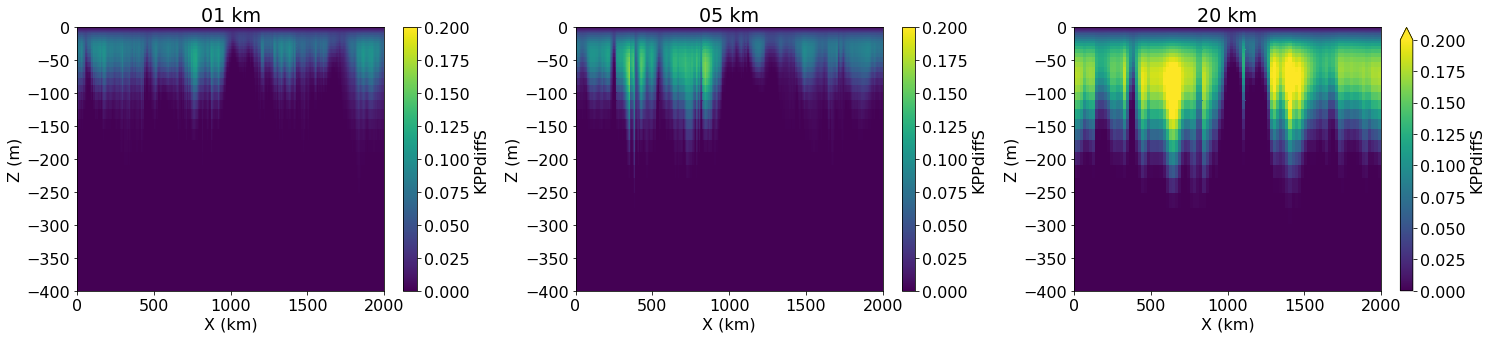

In [92]:
# Mixing LD synoptic (10 day average)
# Surface turbulent buoyancy flux, but not sure what 
res = sorted(res_time.keys())
fig = plt.figure(figsize=(21,5))
plt.rcParams['font.size'] = 16
plt.rcParams['figure.autolayout'] =True
n=0
for key in res:
    ax = fig.add_subplot(131+n)
    

    res_coarse[key].KPPdiffS.isel(time=-1).sel(YC=1000e3, method='nearest').plot(vmax=0.2)
    plt.title(key +' km')
    a=ax.get_xticks()
    a = (a/1e3).astype(int)
    ax.set_xticklabels(a) 
    #ax.set_aspect('equal')
    plt.xlabel('X (km)')
    plt.ylabel('Z (m)')    
    plt.ylim([-400,0])
    n+=1
    
    
plt.tight_layout()
plt.savefig('figures_MLD/KPP_diff_map_synoptic.png', format='png', dpi=300)

/home/dbalwada/miniconda/envs/dhruvenv/lib/python3.5/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


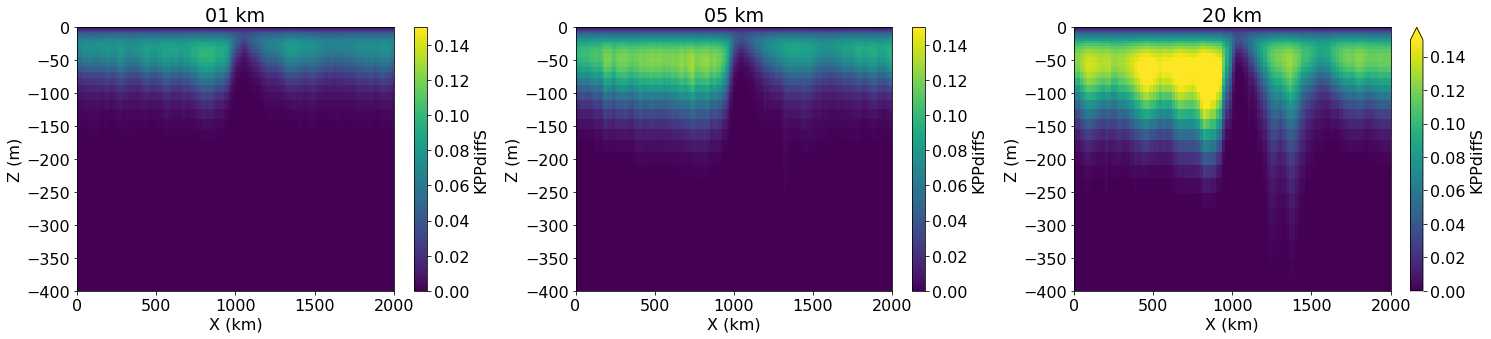

In [93]:
# Mixing LD synoptic (10 day average)
# Surface turbulent buoyancy flux, but not sure what 
res = sorted(res_time.keys())
fig = plt.figure(figsize=(21,5))
plt.rcParams['font.size'] = 16
plt.rcParams['figure.autolayout'] =True
n=0
for key in res:
    ax = fig.add_subplot(131+n)
    

    res_coarse[key].KPPdiffS.sel(YC=1000e3, method='nearest').sel(Zl=slice(0,-450)).mean('time').plot(vmax=0.15)
    plt.title(key +' km')
    a=ax.get_xticks()
    a = (a/1e3).astype(int)
    ax.set_xticklabels(a) 
    plt.xlabel('X (km)')
    plt.ylabel('Z (m)')    
    plt.ylim([-400,0])
    n+=1
    
    
plt.tight_layout()
plt.savefig('figures_MLD/KPP_diff_map_mean.png', format='png', dpi=300)

What are the mixed layer depths?  

It was seen in Takaya's simulations that the mixing layer and mixed layer depths are different. Do we see the same in our case too? 

In [30]:
grid = Grid(res_coarse['01'], periodic='X')

(-1500, 0)

/home/dbalwada/miniconda/envs/dhruvenv/lib/python3.5/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


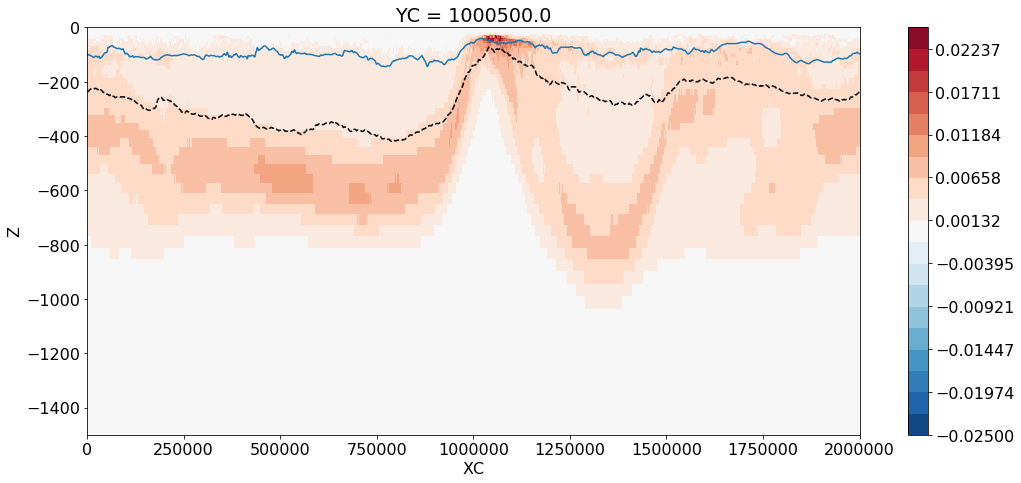

In [43]:
plt.figure(figsize=(15,7))

dT = (res_coarse['01']['T'].isel(YC=1000).mean('time') - 
     res_coarse['01']['T'].isel(YC=1000,Z=0).mean('time'))
dTdZ = grid.diff(res_coarse['01']['T'].isel(YC=1000).mean('time'), 'Z', 
      boundary='extend')/grid.diff(res_coarse['01'].Z, 'Z', boundary='extend')

dTdZ.plot(levels=np.linspace(-0.025,0.025,20))
dT.plot.contour(levels=[-0.8,0.8], colors='k')
plt.plot(res_coarse['01'].XC,  
         -res_coarse['01'].KPPhbl.isel(YC=1000, time=-1))
plt.ylim([-1500,0])

/home/dbalwada/miniconda/envs/dhruvenv/lib/python3.5/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


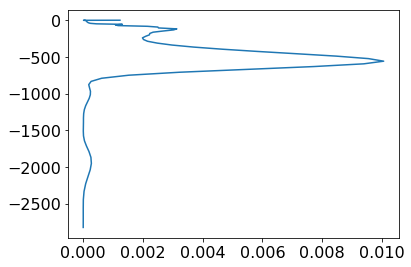

In [48]:
plt.plot(dTdZ.sel(XC=500e3,method='nearest'), dTdZ.Zl)

/home/dbalwada/miniconda/envs/dhruvenv/lib/python3.5/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


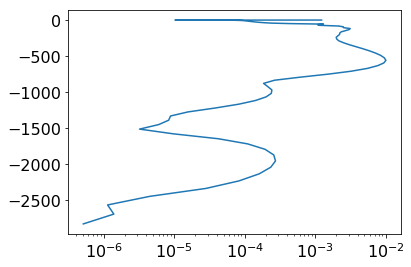

In [49]:
plt.plot(dTdZ.sel(XC=500e3,method='nearest'), dTdZ.Zl)
plt.xscale('log')

In [47]:
dTdZ

<xarray.DataArray (Zl: 76, XC: 2000)>
array([[ 1.215201e-03,  1.215300e-03,  1.215844e-03, ...,  1.215813e-03,
         1.215928e-03,  1.215583e-03],
       [ 3.565137e-05, -6.684633e-06, -5.214013e-05, ...,  3.208624e-05,
         4.857500e-05,  6.773761e-05],
       [ 6.722622e-05,  2.931376e-05, -9.380404e-06, ...,  6.644453e-05,
         8.129684e-05,  9.614914e-05],
       ...,
       [ 1.947097e-06,  2.073077e-06,  2.264236e-06, ...,  2.101289e-06,
         1.986496e-06,  1.923263e-06],
       [ 1.273581e-06,  1.279480e-06,  1.280841e-06, ...,  1.228664e-06,
         1.270406e-06,  1.274943e-06],
       [ 2.885456e-07,  2.712789e-07,  2.352107e-07, ...,  2.950685e-07,
         3.142538e-07,  3.061959e-07]], dtype=float32)
Coordinates:
  * Zl       (Zl) >f4 0.0 -1.0 -2.14 -3.44 -4.93 -6.63 -8.56 -10.76 -13.26 ...
  * XC       (XC) >f4 500.0 1500.0 2500.0 3500.0 4500.0 5500.0 6500.0 7500.0 ...